In [48]:
### https://ml-challenge.mercadolibre.com/

import pandas as pd
import numpy as np
import gc
import xgboost as xgb 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    _ = gc.collect()
    return df

In [49]:
!nvidia-smi

Sat Sep 25 21:33:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   47C    P0    53W / 300W |    867MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

# Load

In [50]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

valid = train.loc[train.date >'2021-03-01'].copy()
gc.collect()

train = train.loc[train.date <= '2021-03-01'].copy()
gc.collect()

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

valid['dcount'] = valid.groupby('sku')['date'].transform('cumcount')
valid['dcount_max'] = valid.groupby('sku')['date'].transform('count')
valid['icount'] = valid['dcount_max'] - valid['dcount']-1
gc.collect()

del train['target_stock']
del valid['target_stock']

train.shape, valid.shape

(37660279, 20)


((18091368, 22), (19568911, 22))

# Build local Validation

In [51]:
%%time
print(valid.shape)
valid['sum_sell'] = valid.groupby('sku')['sold_quantity'].transform('sum')
valid = valid.loc[(valid.dcount_max==30)&(valid.sum_sell>0)].copy()
print(valid.shape)
valid['cs_sell'] = valid.groupby('sku')['sold_quantity'].transform('cumsum')

dt = valid.loc[valid.sold_quantity>0].groupby('sku')['cs_sell'].apply(list).reset_index(name='sells')
np.random.seed(1)
dt['target_stock'] = dt['sells'].apply(lambda x: np.random.choice(x) )
del dt['sells']
dt

(19568911, 22)
(17303490, 23)
CPU times: user 29.5 s, sys: 1.78 s, total: 31.3 s
Wall time: 30.8 s


,sku,target_stock
0,0,11
1,1,15
2,3,1
3,4,2
4,5,12
...,...,...
576778,660911,11
576779,660912,3
576780,660913,2
576781,660914,3


In [52]:
#merge target_stock to train and validation
valid = valid.merge(dt[['sku', 'target_stock']], on='sku', how='left')
train = train.merge(dt[['sku', 'target_stock']], on='sku', how='left')

valid.target_stock.value_counts()

1        2244570
2        1863660
3        1601700
4        1378200
5        1181310
          ...   
1099          30
1098          30
1097          30
1095          30
30030         30
Name: target_stock, Length: 1344, dtype: int64

In [53]:
def metric( ytrue, ypred ):
    tmp = ypred.loc[:,range(30)].cumsum(1).values.copy()
    tmp[tmp>1] = 1
    tmp[tmp<0] = 0
    tmp /= tmp.max(1, keepdims=True)
    return np.sum( (ytrue.loc[:,range(30)].values - tmp)**2 ) / ytrue.shape[0]    


valid['target'] = 1 *(valid['cs_sell'] >= valid['target_stock'])
print('Binary target average:', valid['target'].mean() )

ytrue = valid.pivot(index='sku', columns='dcount', values='target').reset_index()
ytrue = ytrue.reset_index(drop=True)
vals = ytrue.loc[:,range(30)].mean(0).values
vals[1:] = vals[1:] - vals[:-1]

valid['ypred'] = 1/30
VAL = valid.pivot(index='sku', columns='dcount', values='ypred').reset_index()
VAL = VAL.reset_index(drop=True)
VAL = VAL.fillna(1/30)

print( 'Metric for Average Prediction:', metric( ytrue, VAL ) )

Binary target average: 0.5184950550438091
Metric for Average Prediction: 5.1984754231660775


# Build Features

In [54]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8)


train['price_lag'] = train.groupby('sku')['current_price'].transform('cumsum')
train['price_lag'] = train['price_lag'] / (train['sell_act']+1)
train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(1))
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(2)) / (train['current_price']+1e-3)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(3)) / (train['current_price']+1e-3)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(4)) / (train['current_price']+1e-3)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(5)) / (train['current_price']+1e-3)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(6)) / (train['current_price']+1e-3)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(7)) / (train['current_price']+1e-3)
train['price_lag_8'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(8)) / (train['current_price']+1e-3)

train['act_lag'] = train['sell_act'] / (train['dcount']+1)
train['act_lag_1'] = train.groupby('sku')['act_lag'].shift(1)
train['act_lag_2'] = train.groupby('sku')['act_lag'].shift(2)
train['act_lag_3'] = train.groupby('sku')['act_lag'].shift(3)
train['act_lag_4'] = train.groupby('sku')['act_lag'].shift(4)
train['act_lag_5'] = train.groupby('sku')['act_lag'].shift(5)
train['act_lag_6'] = train.groupby('sku')['act_lag'].shift(6)
train['act_lag_7'] = train.groupby('sku')['act_lag'].shift(7)
train['act_lag_8'] = train.groupby('sku')['act_lag'].shift(8)

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1)

train['sold_quantity_log'] = train['sold_quantity']
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7)
train['sold_lag_8'] = train.groupby('sku')['sold_quantity'].shift(8)

# Probability of selling all stock in each day
train['sold_quantity_target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)

_ = gc.collect()

CPU times: user 34.2 s, sys: 7.25 s, total: 41.4 s
Wall time: 41.4 s


In [55]:
train = train.sort_values(['sku','date']).reset_index(drop=True)
_ = gc.collect()

<AxesSubplot:>

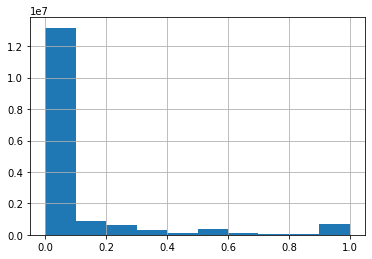

In [56]:
train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)

for i in range(30):
    train['target'+str(i)] = train.groupby('sku')['target'].shift(-(i+1))
train['target'].hist()

In [57]:
feats = ['target'+str(i) for i in range(28)]
train['nonull'] = 28-train[feats].isnull().sum(1)
train['target'] = train[feats].mean(1)
train['weight'] = train['nonull'] / 28
train['weight'] = train['weight'].fillna(0)
train['nonull'].value_counts()

0     2371785
1      574749
2      574405
3      573984
4      572906
5      571614
6      570292
7      569099
8      567932
9      567571
10     567130
11     566018
12     564732
13     563389
14     562240
15     561181
16     560861
17     560247
18     558775
19     557207
20     555727
21     554372
22     552978
23     552487
24     551599
25     550026
26     547804
27     546102
28     544156
Name: nonull, dtype: int64

In [58]:
features = [
    'sold_quantity',
    'current_price',
    'currency',
    'listing_type',
    'shipping_logistic_type',
    'shipping_payment',
    'minutes_active',
    'dow', 
    'item_domain_id',
    'item_id',
    'item_title_id', 'item_title_0', 'item_title_1',
    'site_id',
    'product_id',
    'product_family_id', 
    
    'target_stock',              
    'sell_lag', 'sell_act', 'sell_true',
    'sell_lag_1', 'sell_lag_2', 'sell_lag_3', 'sell_lag_4', 'sell_lag_5', 'sell_lag_6', 'sell_lag_7', 'sell_lag_8',    
    'price_lag', 
    'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_lag_8',
    
    'act_lag',
    'act_lag_1', 'act_lag_2', 'act_lag_3', 'act_lag_4', 'act_lag_5', 'act_lag_6', 'act_lag_7', 'act_lag_8',
    
    'shipping_logistic_type_lag_1',

    'sold_quantity_log',
    'sum_sells_1', 'sum_sells_2', 'sum_sells_3', 'sum_sells_4', 'sum_sells_5', 'sum_sells_6',
    'sold_lag_1', 'sold_lag_2', 'sold_lag_3',  'sold_lag_4', 'sold_lag_5', 'sold_lag_6', 'sold_lag_7', 'sold_lag_8',
    
    'sold_quantity_target',
]

train[features].head()

,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,dow,item_domain_id,item_id,...,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_8,sold_quantity_target
0,0,172.789993,0,0,1,0,0.000000,0,46,83220,...,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,172.789993,0,0,1,0,0.000000,1,46,83220,...,51,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,179.990005,0,0,1,0,872.650024,2,46,83220,...,84,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,179.990005,0,0,1,0,1440.000000,3,46,83220,...,161,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
4,0,179.990005,0,0,1,0,1440.000000,4,46,83220,...,104,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [59]:
train.icount.value_counts()

0     639351
1     638166
2     637768
3     637263
4     636062
5     634601
6     633111
7     631777
8     630470
9     630067
10    629555
11    628333
12    626922
13    625438
14    624165
15    622964
16    622608
17    621937
18    620325
19    618612
20    616976
21    615477
22    613950
23    613405
24    612461
25    610721
26    608270
27    606383
28    604230
Name: icount, dtype: int64

In [60]:
train[[
    'sku',
    'currency',
    'listing_type',
    'shipping_logistic_type',
    'shipping_payment',
    'item_domain_id',
    'item_id',
    'item_title_id', 'item_title_0', 'item_title_1',
    'site_id',
    'product_id',
    'product_family_id'
]].nunique()

sku                       639351
currency                       4
listing_type                   2
shipping_logistic_type         3
shipping_payment               2
item_domain_id              8383
item_id                   501318
item_title_id             464472
item_title_0              286162
item_title_1              409828
site_id                        3
product_id                 14823
product_family_id          28860
dtype: int64

In [61]:
train['fold'] = train['item_id'] % 5
train['fold'].value_counts()

4    3641734
2    3630232
1    3612277
3    3603819
0    3603306
Name: fold, dtype: int64

In [62]:
train = reduce_mem(train)
_ = gc.collect()

In [63]:
%%time

params = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.75,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': train.target.mean(),
    'tree_method': 'gpu_hist',
    'verbosity': 1,
    #'nthread': 16,
}

MODELS = []
NROUNDS = []
OOF = pd.DataFrame()
for fold in range(5):
    
    ind = (train.fold!=fold)&(train.target.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()
    
    ind = (train.fold==fold)&(train.target.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dvalid = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=3000,#np.mean(NROUNDS),
        evals=[(dvalid,'valid')],
        early_stopping_rounds=33,
        verbose_eval=100,
        ) ; gc.collect()
    NROUNDS.append(model.best_iteration)
    MODELS.append(model)

0 12587031
0 3132552
[0]	valid-rmse:0.12179
[100]	valid-rmse:0.09228
[200]	valid-rmse:0.09189
[300]	valid-rmse:0.09177
[400]	valid-rmse:0.09170
[500]	valid-rmse:0.09166
[600]	valid-rmse:0.09164
[700]	valid-rmse:0.09162
[772]	valid-rmse:0.09161
1 12586507
1 3133076
[0]	valid-rmse:0.12164
[100]	valid-rmse:0.09242
[200]	valid-rmse:0.09206
[300]	valid-rmse:0.09193
[400]	valid-rmse:0.09186
[500]	valid-rmse:0.09182
[600]	valid-rmse:0.09180
[700]	valid-rmse:0.09178
[701]	valid-rmse:0.09178
2 12561599
2 3157984
[0]	valid-rmse:0.12172
[100]	valid-rmse:0.09233
[200]	valid-rmse:0.09196
[300]	valid-rmse:0.09184
[400]	valid-rmse:0.09178
[500]	valid-rmse:0.09175
[594]	valid-rmse:0.09174
3 12586867
3 3132716
[0]	valid-rmse:0.12126
[100]	valid-rmse:0.09220
[200]	valid-rmse:0.09183
[300]	valid-rmse:0.09170
[400]	valid-rmse:0.09164
[500]	valid-rmse:0.09160
[600]	valid-rmse:0.09158
[678]	valid-rmse:0.09157
4 12556328
4 3163255
[0]	valid-rmse:0.12139
[100]	valid-rmse:0.09241
[200]	valid-rmse:0.09207
[300]

In [64]:
ind = (train.icount==0)
tmp = train.loc[ind].copy()

dtest = xgb.DMatrix( tmp[features]) ; gc.collect()
tmp = tmp.reset_index(drop=True)

ypred = 1*MODELS[0].predict(dtest)
if len(MODELS)>1:
    for m in MODELS[1:]:
        ypred += m.predict(dtest)
    ypred /= len(MODELS)
    
tmp['ypred'] = np.clip(ypred,0,1)
tmp.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,target24,target25,target26,target27,target28,target29,nonull,weight,fold,ypred
0,0,2021-03-01,0,179.990005,0,0,1,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0.007881
1,1,2021-03-01,2,135.899994,0,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.061890
2,3,2021-03-01,0,399.000000,1,1,0,0,0.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.013311
3,4,2021-03-01,2,118.000000,0,1,0,0,243.278488,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,4,0.146886
4,5,2021-03-01,1,579.630005,1,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.055957


In [65]:
ind = (train.icount==0)
tmp = train.loc[ind].copy()

tmp['ypred'] = np.nan
for fold in range(5):
    dtest = xgb.DMatrix( tmp.loc[tmp.fold==fold,features]) ; gc.collect()
    tmp = tmp.reset_index(drop=True)
    tmp.loc[tmp.fold==fold, 'ypred'] = MODELS[fold].predict(dtest)
    
tmp['ypred'] = tmp['ypred'].clip(0,1)
tmp.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,target24,target25,target26,target27,target28,target29,nonull,weight,fold,ypred
0,0,2021-03-01,0,179.990005,0,0,1,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0.008834
1,1,2021-03-01,2,135.899994,0,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.057455
2,3,2021-03-01,0,399.000000,1,1,0,0,0.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.015505
3,4,2021-03-01,2,118.000000,0,1,0,0,243.278488,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,4,0.152587
4,5,2021-03-01,1,579.630005,1,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.055352


In [76]:
PRED = tmp.groupby('sku')['ypred'].agg('mean').reset_index()
PRED['ypred'] = PRED['ypred'].clip(0,1)
PRED

,sku,ypred
0,0,0.008834
1,1,0.057455
2,3,0.015505
3,4,0.152587
4,5,0.055352
...,...,...
639346,660911,0.050061
639347,660912,0.123909
639348,660913,0.103228
639349,660914,0.178480


In [67]:
imp = pd.DataFrame().from_dict(MODELS[-1].get_fscore(), orient='index').sort_values(0, ascending=False).reset_index()
imp.head(40)

,index,0
0,item_domain_id,7388
1,item_id,6644
2,current_price,6381
3,item_title_0,6107
4,item_title_1,5802
5,item_title_id,4973
6,price_lag,4690
7,sell_true,4475
8,sum_sells_1,4213
9,target_stock,4186


In [68]:
imp.tail(40)

,index,0
23,sold_quantity_target,1921
24,price_lag_8,1913
25,sum_sells_2,1853
26,price_lag_3,1793
27,sold_lag_1,1777
28,sold_quantity,1735
29,sell_lag_5,1706
30,sum_sells_5,1691
31,sell_lag_6,1653
32,sell_lag_7,1642


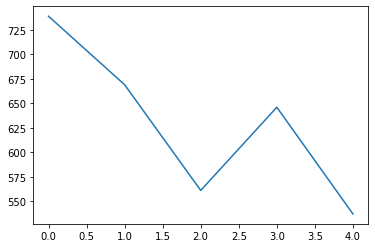

In [69]:
plt.plot(NROUNDS)

In [78]:
val = VAL.copy()
for i in range(1,30):
    val[i] = 1. / 30
val[29] = 1.

var = np.arange(0,30)
var = 1-np.log(15*var+1)
var -= var.min()
var /= var.max()
for i in range(9):
    val[i] = val[['sku']].merge(dt1, on='sku', how='left')['ypred'].values * var[i]
    val[i] = val[i].fillna(1/30)
    val[i] = val[i].clip(0,1)

for i in range(9,30):
    val[i] = val[i].values*0.95 + val[i-1].values*0.05
    
for i in range(1,30):
    val[i] = (val[i-1] + val[i] ).clip(0,1)

for i in range(28,9,-1):
    val[i] = val[i].values*0.55 + val[i+1].values*0.45
    
for i in range(29,0,-1):
    val[i] = val[i] - val[i-1]
    val[i] = val[i].clip(0,1)

print( metric( ytrue, val ) )

4.065115701984483


In [72]:
val.head(20)

dcount,sku,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,0.008834,0.004804,0.003843,0.003269,0.002859,0.002539,0.002277,0.002056,0.001863,...,0.033434,0.033557,0.033831,0.034439,0.035790,0.038792,0.045464,0.060291,0.093238,0.166456
1,1,0.057455,0.031245,0.024992,0.021261,0.018593,0.016515,0.014812,0.013369,0.012118,...,0.033360,0.033392,0.033464,0.033623,0.033978,0.034765,0.036515,0.040404,0.049046,0.068250
2,3,0.015505,0.008432,0.006744,0.005737,0.005017,0.004457,0.003997,0.003608,0.003270,...,0.033424,0.033535,0.033780,0.034327,0.035541,0.038240,0.044236,0.057562,0.087175,0.152982
3,4,0.152587,0.082977,0.066372,0.056464,0.049378,0.043858,0.039336,0.035505,0.032182,...,0.027482,0.020330,0.004437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.055352,0.030101,0.024077,0.020483,0.017912,0.015910,0.014269,0.012880,0.011674,...,0.033363,0.033399,0.033480,0.033659,0.034056,0.034939,0.036902,0.041264,0.050958,0.072498
5,6,0.140470,0.076389,0.061102,0.051980,0.045457,0.040376,0.036213,0.032686,0.029627,...,0.031260,0.028725,0.023092,0.010576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7,0.045748,0.024878,0.019900,0.016929,0.014804,0.013150,0.011794,0.010645,0.009649,...,0.033378,0.033432,0.033552,0.033820,0.034414,0.035735,0.038670,0.045192,0.059686,0.091896
7,9,0.276429,0.150323,0.120241,0.102291,0.089454,0.079454,0.071262,0.064322,0.046224,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,10,0.174340,0.094807,0.075835,0.064514,0.056418,0.050111,0.044944,0.040567,0.036771,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,11,0.062542,0.034011,0.027205,0.023143,0.020239,0.017977,0.016123,0.014553,0.013191,...,0.033352,0.033375,0.033425,0.033538,0.033788,0.034344,0.035579,0.038323,0.044422,0.057975


<AxesSubplot:xlabel='dcount'>

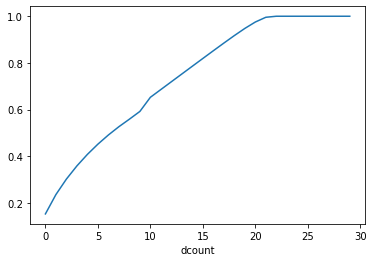

In [79]:
val.loc[3,range(30)].cumsum().plot()

<AxesSubplot:xlabel='dcount'>

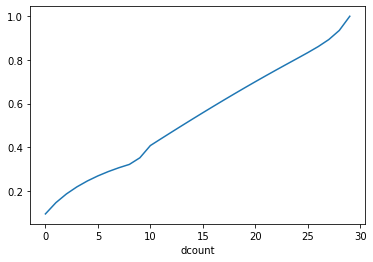

In [80]:
val.loc[:,range(30)].cumsum(1).mean().plot()

In [81]:
val.to_csv('validation-day-1-A.csv', index=False)

# Full train

In [30]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

train.shape

(37660279, 20)


(37660279, 23)

In [31]:
test = pd.read_csv('../input/test_data.csv')
test.head()

,sku,target_stock
0,464801,3
1,645793,4
2,99516,8
3,538100,8
4,557191,10


In [32]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8)


train['price_lag'] = train.groupby('sku')['current_price'].transform('cumsum')
train['price_lag'] = train['price_lag'] / (train['sell_act']+1)
train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(1))
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(2)) / (train['current_price']+1e-3)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(3)) / (train['current_price']+1e-3)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(4)) / (train['current_price']+1e-3)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(5)) / (train['current_price']+1e-3)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(6)) / (train['current_price']+1e-3)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(7)) / (train['current_price']+1e-3)
train['price_lag_8'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(8)) / (train['current_price']+1e-3)

train['act_lag'] = train['sell_act'] / (train['dcount']+1)
train['act_lag_1'] = train.groupby('sku')['act_lag'].shift(1)
train['act_lag_2'] = train.groupby('sku')['act_lag'].shift(2)
train['act_lag_3'] = train.groupby('sku')['act_lag'].shift(3)
train['act_lag_4'] = train.groupby('sku')['act_lag'].shift(4)
train['act_lag_5'] = train.groupby('sku')['act_lag'].shift(5)
train['act_lag_6'] = train.groupby('sku')['act_lag'].shift(6)
train['act_lag_7'] = train.groupby('sku')['act_lag'].shift(7)
train['act_lag_8'] = train.groupby('sku')['act_lag'].shift(8)

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1)

train['sold_quantity_log'] = train['sold_quantity']
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7)
train['sold_lag_8'] = train.groupby('sku')['sold_quantity'].shift(8)

train['sold_quantity_target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)

_ = gc.collect()

CPU times: user 1min 9s, sys: 15.4 s, total: 1min 24s
Wall time: 1min 24s


In [33]:
features = [
    'sold_quantity',
    'current_price',
    'currency',
    'listing_type',
    'shipping_logistic_type',
    'shipping_payment',
    'minutes_active',
    'dow', 
    'item_domain_id',
    'item_id',
    'item_title_id', 'item_title_0', 'item_title_1',
    'site_id',
    'product_id',
    'product_family_id', 
    
    'target_stock',              
    'sell_lag', 'sell_act', 'sell_true',
    'sell_lag_1', 'sell_lag_2', 'sell_lag_3', 'sell_lag_4', 'sell_lag_5', 'sell_lag_6', 'sell_lag_7', 'sell_lag_8',    
    'price_lag', 
    'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_lag_8',
    
    'act_lag',
    'act_lag_1', 'act_lag_2', 'act_lag_3', 'act_lag_4', 'act_lag_5', 'act_lag_6', 'act_lag_7', 'act_lag_8',
    
    'shipping_logistic_type_lag_1',

    'sold_quantity_log',
    'sum_sells_1', 'sum_sells_2', 'sum_sells_3', 'sum_sells_4', 'sum_sells_5', 'sum_sells_6',
    'sold_lag_1', 'sold_lag_2', 'sold_lag_3',  'sold_lag_4', 'sold_lag_5', 'sold_lag_6', 'sold_lag_7', 'sold_lag_8',
    
    'sold_quantity_target',
]

train[features].head()

,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,dow,item_domain_id,item_id,...,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_8,sold_quantity_target
6094273,0,172.789993,0,0,1,0,0.000000,0,46,83220,...,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6094274,0,172.789993,0,0,1,0,0.000000,1,46,83220,...,54,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6094275,0,179.990005,0,0,1,0,872.650024,2,46,83220,...,87,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6094276,0,179.990005,0,0,1,0,1440.000000,3,46,83220,...,164,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
6094277,0,179.990005,0,0,1,0,1440.000000,4,46,83220,...,125,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [34]:
%%time

train = train.sort_values(['sku','date']).reset_index(drop=True)
_ = gc.collect()

CPU times: user 13.1 s, sys: 4.92 s, total: 18 s
Wall time: 18 s


# Calc probability of sell for the following 30 days

CPU times: user 34.7 s, sys: 9.07 s, total: 43.8 s
Wall time: 43.7 s


<AxesSubplot:>

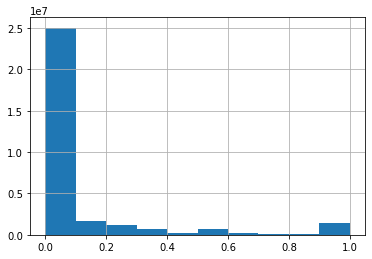

In [35]:
%%time

train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)
for i in range(30):
    train['target'+str(i)] = train.groupby('sku')['target'].shift(-(i+1))
    
train['target'].hist()

In [36]:
feats = ['target'+str(i) for i in range(30)]

train[ feats].head()

,target0,target1,target2,target3,target4,target5,target6,target7,target8,target9,...,target20,target21,target22,target23,target24,target25,target26,target27,target28,target29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Average sell for next 30 days
# Weight by number of days available in the next 30 days

In [37]:
feats = ['target'+str(i) for i in range(30)]
train['nonull'] = 30-train[feats].isnull().sum(1)
train['target'] = train[feats].mean(1)
train['weight'] = train['nonull'] / 30
train['weight'] = train['weight'].fillna(0)
train['nonull'].value_counts()

30    14992976
0      6927324
1       550920
2       550362
3       549817
4       549660
5       549433
6       548816
7       548200
8       547525
9       546812
10      546005
11      545799
12      545466
13      544799
14      543976
15      543208
16      542430
17      541734
18      541465
19      541067
20      540252
21      539262
22      538273
23      537386
24      536441
25      536098
26      535668
27      534241
28      533032
29      531832
Name: nonull, dtype: int64

In [38]:
train['fold'] = train['item_id'] % 5
train['fold'].value_counts()

4    7578799
2    7555281
1    7518555
0    7504564
3    7503080
Name: fold, dtype: int64

In [39]:
train = reduce_mem(train)
_ = gc.collect()

In [40]:
params = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.75,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': train.target.mean(),
    'tree_method': 'hist',
    'verbosity': 1,
    'nthread': 16,
}

NROUNDS = []
MODELS = []
for fold in range(5):
    
    ind = (train.fold!=fold)&(train.target.notnull())&(train.sku.isin(test.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()
    
    ind = (train.fold==fold)&(train.target.notnull())&(train.sku.isin(test.sku)) 
    print(fold, np.sum(ind))
    dvalid = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=3000,#np.mean(NROUNDS),
        evals=[(dvalid,'valid')],
        early_stopping_rounds=33,
        verbose_eval=100,
        ) ; gc.collect()
    
    NROUNDS.append(model.best_iteration)
    MODELS.append(model)

0 24596119
0 6136836
[0]	valid-rmse:0.12143
[100]	valid-rmse:0.08823
[200]	valid-rmse:0.08775
[300]	valid-rmse:0.08756
[400]	valid-rmse:0.08746
[500]	valid-rmse:0.08738
[600]	valid-rmse:0.08733
[700]	valid-rmse:0.08729
[800]	valid-rmse:0.08726
[900]	valid-rmse:0.08725
[954]	valid-rmse:0.08725
1 24596769
1 6136186
[0]	valid-rmse:0.11999
[100]	valid-rmse:0.08734
[200]	valid-rmse:0.08686
[300]	valid-rmse:0.08667
[400]	valid-rmse:0.08658
[500]	valid-rmse:0.08651
[600]	valid-rmse:0.08647
[700]	valid-rmse:0.08644
[800]	valid-rmse:0.08642
[900]	valid-rmse:0.08641
[1000]	valid-rmse:0.08639
[1013]	valid-rmse:0.08639
2 24576543
2 6156412
[0]	valid-rmse:0.12156
[100]	valid-rmse:0.08803
[200]	valid-rmse:0.08754
[300]	valid-rmse:0.08737
[400]	valid-rmse:0.08728
[500]	valid-rmse:0.08722
[600]	valid-rmse:0.08718
[700]	valid-rmse:0.08715
[800]	valid-rmse:0.08713
[900]	valid-rmse:0.08711
[934]	valid-rmse:0.08711
3 24610525
3 6122430
[0]	valid-rmse:0.12189
[100]	valid-rmse:0.08807
[200]	valid-rmse:0.087

# Use last day of train to predict for test

In [41]:
ind = (train.icount==0)
tmp = train.loc[ind].copy()

dtest = xgb.DMatrix( tmp[features]) ; gc.collect()
tmp = tmp.reset_index(drop=True)

ypred = 1*MODELS[0].predict(dtest)
if len(MODELS)>1:
    for m in MODELS[1:]:
        ypred += m.predict(dtest)
    ypred /= len(MODELS)
    
tmp['ypred'] = np.clip(ypred,0,1)
tmp.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,target_stock,...,target24,target25,target26,target27,target28,target29,nonull,weight,fold,ypred
0,0,2021-03-31,0,179.990005,0,0,0,0,1440.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0.212336
1,1,2021-03-31,1,135.899994,0,1,0,0,1440.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.057699
2,2,2021-03-31,0,219.000000,1,1,0,1,1440.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,0.033577
3,3,2021-03-31,1,399.000000,1,1,0,0,1440.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.102130
4,4,2021-03-31,0,118.000000,0,1,0,0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,4,0.126743


# Aggregate predictions

In [42]:
PRED = tmp.groupby('sku')['ypred'].agg('mean').reset_index()
PRED['ypred'] = PRED['ypred'].clip(0,1)
PRED

,sku,ypred
0,0,0.212336
1,1,0.057699
2,2,0.033577
3,3,0.102130
4,4,0.126743
...,...,...
660911,660911,0.099111
660912,660912,0.129149
660913,660913,0.077161
660914,660914,0.066838


# Load test

In [43]:
test = pd.read_csv('../input/test_data.csv')
print( test.shape, test.sku.nunique() )
test = test.merge( PRED, on='sku', how='left' )
print( test.ypred.isnull().sum() )
test.head()

(551472, 2) 551472
0


,sku,target_stock,ypred
0,464801,3,0.065655
1,645793,4,0.074040
2,99516,8,0.352272
3,538100,8,0.187728
4,557191,10,0.065441


# Apply predictions + postprocessing to test

(551472, 30)


<AxesSubplot:>

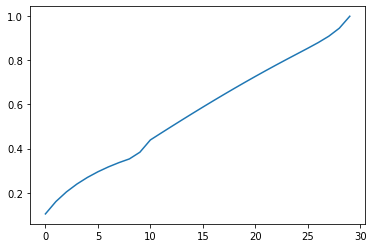

In [44]:
sub = pd.read_csv('../input/sample_submission.csv', header=None)
for i in range(30):
    sub[i] = 1. / 30
sub[29] = 1.
print( sub.shape )

var = np.arange(0,30)
var = 1-np.log(15*var+1)
var -= var.min()
var /= var.max()
for i in range(9):
    sub[i] = test['ypred'].values * var[i]
    sub[i] = sub[i].fillna(1/30)
    sub[i] = sub[i].clip(0,1)

for i in range(9,30):
    sub[i] = sub[i].values*0.95 + sub[i-1].values*0.05
    
for i in range(1,30):
    sub[i] = (sub[i-1] + sub[i] ).clip(0,1)

for i in range(28,9,-1):
    sub[i] = sub[i].values*0.55 + sub[i+1].values*0.45
    
for i in range(29,0,-1):
    sub[i] = sub[i] - sub[i-1]
    sub[i] = sub[i].clip(0,1)

sub.loc[:,range(30)].cumsum(1).mean().plot()

In [45]:
sub.head(40)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.065655,0.035704,0.028559,0.024295,0.021247,0.018871,0.016926,0.015277,0.013848,0.032359,...,0.033347,0.033364,0.033402,0.033486,0.033672,0.034086,0.035006,0.037050,0.041593,0.051687
1,0.074040,0.040263,0.032206,0.027398,0.023960,0.021281,0.019087,0.017228,0.015616,0.032447,...,0.033334,0.033336,0.033339,0.033345,0.033360,0.033392,0.033463,0.033621,0.033972,0.034753
2,0.352272,0.191567,0.153231,0.130356,0.113998,0.058576,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.187728,0.102087,0.081658,0.069468,0.060750,0.053959,0.048395,0.043682,0.039594,0.033646,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.065441,0.035587,0.028466,0.024216,0.021177,0.018810,0.016870,0.015227,0.013802,0.032357,...,0.033348,0.033365,0.033404,0.033489,0.033680,0.034104,0.035045,0.037138,0.041787,0.052120
5,0.639106,0.347549,0.013345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.283167,0.153988,0.123172,0.104784,0.091635,0.081391,0.072999,0.065890,0.022974,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.032312,0.017572,0.014055,0.011957,0.010457,0.009288,0.008330,0.007519,0.006815,0.032007,...,0.033398,0.033477,0.033654,0.034045,0.034915,0.036848,0.041143,0.050688,0.071898,0.119033
8,0.117656,0.063982,0.051178,0.043538,0.038074,0.033818,0.030331,0.027377,0.024815,0.032907,...,0.033070,0.032749,0.032034,0.030447,0.026919,0.019079,0.001656,0.000000,0.000000,0.000000
9,0.065238,0.035477,0.028377,0.024141,0.021111,0.018751,0.016818,0.015180,0.013759,0.032355,...,0.033348,0.033366,0.033405,0.033493,0.033688,0.034121,0.035083,0.037221,0.041972,0.052531


In [46]:
sub.tail(40)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
551432,0.160546,0.087306,0.069834,0.059409,0.051954,0.046146,0.041388,0.037357,0.033861,0.033360,...,0.021346,0.006695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
551433,0.177166,0.096344,0.077064,0.065559,0.057332,0.050923,0.045672,0.041225,0.037367,0.033535,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
551434,0.070177,0.038163,0.030526,0.025969,0.022710,0.020171,0.018091,0.016329,0.014801,0.032407,...,0.033340,0.033349,0.033368,0.033410,0.033503,0.033711,0.034174,0.035201,0.037483,0.042555
551435,0.053183,0.028921,0.023133,0.019680,0.017210,0.015286,0.013710,0.012375,0.011217,0.032228,...,0.033366,0.033407,0.033496,0.033695,0.034137,0.035119,0.037301,0.042151,0.052929,0.076880
551436,0.067309,0.036603,0.029278,0.024907,0.021782,0.019347,0.017352,0.015662,0.014196,0.032376,...,0.033345,0.033359,0.033389,0.033458,0.033610,0.033949,0.034701,0.036374,0.040090,0.048347
551437,0.190779,0.103746,0.082985,0.070597,0.061737,0.054836,0.049182,0.044392,0.040238,0.033679,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
551438,0.193691,0.105330,0.084252,0.071674,0.062680,0.055673,0.049932,0.045070,0.040852,0.033709,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
551439,0.196569,0.106895,0.085504,0.072739,0.063611,0.056500,0.050674,0.045739,0.041459,0.033740,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
551440,0.018803,0.010225,0.008179,0.006958,0.006085,0.005405,0.004847,0.004375,0.003966,0.031865,...,0.033419,0.033523,0.033756,0.034272,0.035418,0.037966,0.043629,0.056213,0.084177,0.146320
551441,0.016796,0.009134,0.007306,0.006215,0.005435,0.004828,0.004330,0.003908,0.003543,0.031844,...,0.033422,0.033530,0.033771,0.034305,0.035493,0.038133,0.043999,0.057034,0.086001,0.150373


In [47]:
sub.to_csv('submission-day-1-A.csv', index=False, header=None, float_format='%.4f')
# 3.9682700749312447